Setup

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Data

In [0]:
# To load in our data

#data = pd.read_csv('drive/My Drive/CS 598PS Final Project/data/nfl_row_processed_2_norm.csv')
#target = pd.read_csv('drive/My Drive/CS 598PS Final Project/nfl_bigbowl_data_mod_target.csv', header=None)

In [0]:
# To load in the data from Kaggle-NB

data = pd.read_csv('drive/My Drive/CS 598PS Final Project/data/nfl_enhanced_db.csv', header=0, index_col=0)
target = data['Yards']
data.drop(['GameId','PlayId','Yards'], axis=1, inplace=True)

In [0]:
data

,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,RusherDir,RusherS,RusherA,RusherX,RusherY,v_horizontal,v_vertical,PlayerHeight_dense,PlayerAge,WindSpeed_dense,Dir_sin,Dir_cos,diffScoreBeforePlay,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox
0,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,114.26,3.63,3.35,41.25,30.53,3.309436,1.491487,70,25.596251,8.0,0.911690,-0.410878,0,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0
1,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,47.80,3.06,2.41,48.93,27.16,2.266862,2.055465,70,25.596252,8.0,0.740805,0.671721,0,48.93,27.16,3.06,2.41,0.34,149.30,47.80,53.0,1,1,10,6.0
2,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,138.04,5.77,2.42,71.34,19.11,3.857889,4.290640,70,25.596253,8.0,0.668612,-0.743612,0,71.34,19.11,5.77,2.42,0.60,219.18,138.04,75.0,1,1,10,7.0
3,3.53,0,0,0.918096,9.791231,5.549379,1.983128,4.528002,9.791231,6.309354,1.834174,84.56,4.45,3.20,104.47,25.36,4.429957,0.421875,71,26.852933,8.0,0.995496,0.094803,0,104.47,25.36,4.45,3.20,0.46,173.78,84.56,108.0,1,2,2,9.0
4,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,21.214806,11.056456,5.900009,157.92,3.90,2.53,29.99,27.12,1.466013,3.613974,71,22.091819,8.0,0.375901,-0.926660,7,29.99,27.12,3.90,2.53,0.44,34.27,157.92,35.0,1,1,10,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23166,4.57,0,0,0.575847,19.341419,6.736412,4.514974,2.942329,19.341419,8.243270,5.075063,69.77,3.99,3.38,70.43,32.27,3.743865,1.379700,73,27.041779,5.0,0.938312,0.345790,3,70.43,32.27,3.99,3.38,0.39,72.56,69.77,75.0,4,1,10,8.0
23167,4.00,0,0,1.151217,25.500196,9.827962,7.474030,2.808932,25.500196,11.779213,7.739310,150.98,4.18,2.95,31.00,30.99,2.027780,3.655203,69,25.861781,5.0,0.485115,-0.874450,0,31.00,30.99,4.18,2.95,0.40,122.97,150.98,35.0,4,1,10,6.0
23168,4.07,0,0,0.776209,19.454503,8.272970,5.548527,3.595998,19.454503,8.825731,5.317643,41.25,4.67,3.68,39.93,29.20,3.079145,3.511092,69,25.861783,5.0,0.659346,0.751840,0,39.93,29.20,4.67,3.68,0.45,63.11,41.25,44.0,4,3,1,7.0
23169,3.81,0,0,0.584637,19.113474,8.202171,5.833721,4.090880,19.113474,9.062557,5.568974,41.24,4.23,2.43,81.19,23.75,2.788478,3.180769,71,24.290258,5.0,0.659215,0.751955,0,81.19,23.75,4.23,2.43,0.41,66.34,41.24,85.0,4,1,10,7.0


In [0]:
target

0         8
1         3
2         5
3         2
4         7
         ..
23166     1
23167     4
23168     4
23169     2
23170    11
Name: Yards, Length: 23171, dtype: int64

In [0]:
data.columns

Index(['back_from_scrimmage', 'back_oriented_down_field',
       'back_moving_down_field', 'min_dist', 'max_dist', 'mean_dist',
       'std_dist', 'def_min_dist', 'def_max_dist', 'def_mean_dist',
       'def_std_dist', 'RusherDir', 'RusherS', 'RusherA', 'RusherX', 'RusherY',
       'v_horizontal', 'v_vertical', 'PlayerHeight_dense', 'PlayerAge',
       'WindSpeed_dense', 'Dir_sin', 'Dir_cos', 'diffScoreBeforePlay', 'X',
       'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'YardLine', 'Quarter',
       'Down', 'Distance', 'DefendersInTheBox'],
      dtype='object')

In [0]:
data.isnull().sum()

back_from_scrimmage         0
back_oriented_down_field    0
back_moving_down_field      0
min_dist                    0
max_dist                    0
mean_dist                   0
std_dist                    0
def_min_dist                0
def_max_dist                0
def_mean_dist               0
def_std_dist                0
RusherDir                   0
RusherS                     0
RusherA                     0
RusherX                     0
RusherY                     0
v_horizontal                0
v_vertical                  0
PlayerHeight_dense          0
PlayerAge                   0
WindSpeed_dense             0
Dir_sin                     0
Dir_cos                     0
diffScoreBeforePlay         0
X                           0
Y                           0
S                           0
A                           0
Dis                         0
Orientation                 0
Dir                         0
YardLine                    0
Quarter                     0
Down      

In [0]:
data_np = data.to_numpy(dtype='float')
target_np = target.to_numpy(dtype='int')
data_np.shape, target_np.shape

((23171, 36), (23171,))

In [0]:
from sklearn.model_selection import train_test_split as ttsplit

X_train, X_test, Y_train, Y_test = ttsplit(data_np, target_np, test_size=0.2)
X_train, X_val, Y_train, Y_val = ttsplit(X_train, Y_train, test_size=0.2)

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

Helpers

In [0]:
def Y_to_199_one_hot(Y):
  y = np.zeros((Y.shape[0], 199))
  for idx, target in enumerate(list(Y)):
      y[idx][target] = 1
  return y

In [0]:
def calc_crps(Y, Y_pred):
  y_true = np.clip(np.cumsum(Y, axis=1), 0, 1)
  y_pred = np.clip(np.cumsum(Y_pred, axis=1), 0, 1)
  val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * Y.shape[0])
  val_s = np.round(val_s, 6)
  return val_s

Neural Net Helpers

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import cat
import torch.optim as optim
from torch.utils import data as data_torch
from torch.autograd import Variable

In [0]:
class Dataset(data_torch.Dataset):

  'Characterizes a dataset for PyTorch'
  def __init__(self, X, y):
        'Initialization'
        self.y = y
        self.X = X

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]

        # Load data and get label
        y = self.y[index]

        return X, y

In [0]:
def eval(dataloader, net, loss_f):
    
    net.eval()
    sum_batch_loss = 0.0
    for data in dataloader:
      with torch.no_grad(): 
          batch, yards = data
          if torch.cuda.is_available():
              batch = batch.cuda()
              yards = yards.cuda()
          pred_yards = net(Variable(batch).float())
          loss = loss_f(pred_yards.view(-1, 199), yards.long().view(-1))
          sum_batch_loss += loss.item()
    sum_batch_loss /= len(dataloader)
    return sum_batch_loss

In [0]:
def eval_crps(dataloader, net):
    
    net.eval()
    sum_batch_loss = 0.0
    for data in dataloader:
      with torch.no_grad(): 
          batch, yards = data
          if torch.cuda.is_available():
              batch = batch.cuda()
              yards = yards.cuda()
          pred_yards = net(Variable(batch).float())
          loss = calc_crps(Y_to_199_one_hot(yards.cpu().numpy()), pred_yards.cpu().numpy())
          sum_batch_loss += loss
    sum_batch_loss /= len(dataloader)
    return sum_batch_loss

Neural Nets

In [0]:
class NFLRegressorNet(nn.Module):
    def __init__(self, X_train):
        super(NFLRegressorNet, self).__init__()
        
        Nsamples, Nfeatures = X_train.shape
        print("Nsapmles: {}, Nfeatures: {}".format(Nsamples, Nfeatures))

        self.net = nn.Sequential(
    
            nn.Linear(Nfeatures, 1024),
            nn.RReLU(1024),
            nn.Dropout(0.4),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(512),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.RReLU(256),
            nn.Dropout(0.5),
            nn.BatchNorm1d(256),
            nn.Linear(256, 100),
            nn.ReLU(100),
            nn.Dropout(0.4),
            nn.BatchNorm1d(100),
            nn.Linear(100, 1),
        )

       
    def forward(self, x):
      
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        out = self.net(x) # 512
        return out

In [0]:
class NFLClassifierNet(nn.Module):
    def __init__(self, X_train):
        super(NFLClassifierNet, self).__init__()
        
        Nsamples, Nfeatures = X_train.shape
        print("Nsapmles: {}, Nfeatures: {}".format(Nsamples, Nfeatures))

        self.net = nn.Sequential(
    
            nn.Linear(Nfeatures, 1024),
            nn.ReLU(1024),
            nn.Dropout(0.5),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(512),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(256),
            nn.Dropout(0.5),
            nn.BatchNorm1d(256),
            nn.Linear(256, 199),
            nn.ReLU(199),
            nn.Dropout(0.5),
            nn.BatchNorm1d(199),
            nn.Softmax(1)
        )

       
    def forward(self, x):
      
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        out = self.net(x) # 512
        return out

Training and Eval

In [0]:
# For Classification

trainset = Dataset(X_train, Y_train+99)
valset = Dataset(X_val, Y_val+99)
testset = Dataset(X_test, Y_test+99)

In [0]:
# For Regression

trainset = Dataset(X_train, Y_train)
valset = Dataset(X_val, Y_val)
testset = Dataset(X_test, Y_test)

In [0]:
TRAIN_BS = 200
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BS, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(valset, batch_size=len(valset), num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), num_workers=1)

In [0]:
NET_TYPE = 'regressor' # 'classifier'
net = NFLRegressorNet(X_train)
if torch.cuda.is_available():
  net = net.cuda()
# summary(net, (3, 32, 32))

In [0]:
NET_TYPE = 'classifier' # 'regressor'
net = NFLClassifierNet(X_train)
if torch.cuda.is_available():
  net = net.cuda()
# summary(net, (3, 32, 32))

Nsapmles: 14828, Nfeatures: 36


In [0]:
# Define our optimizer and our loss function

loss_f = nn.CrossEntropyLoss() #nn.L1Loss() #nn.SmoothL1Loss() #
lr = 1e-1
optimizer = optim.Adam(net.parameters(), lr=lr, amsgrad=False) #  #optim.SGD(net.parameters(), lr=lr, momentum=0.9) 
EPOCHS = 50
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       patience=10,
                                                       verbose=True
                                                       )

In [0]:
train_loss_over_epochs = []
val_accuracy_over_epochs = []
if NET_TYPE == 'classifier':
  val_crps_over_epochs = []

[1] loss: 5.175594
CRPS Validation Score: 0.018177
Mean Validation set loss over batches: 5.168470
[2] loss: 5.175622
CRPS Validation Score: 0.018162
Mean Validation set loss over batches: 5.171396
[3] loss: 5.175343
CRPS Validation Score: 0.018769
Mean Validation set loss over batches: 5.172378
[4] loss: 5.171543
CRPS Validation Score: 0.019376
Mean Validation set loss over batches: 5.174847
[5] loss: 5.169824
CRPS Validation Score: 0.019476
Mean Validation set loss over batches: 5.176639
[6] loss: 5.166585
CRPS Validation Score: 0.019475
Mean Validation set loss over batches: 5.172748
[7] loss: 5.167193
CRPS Validation Score: 0.019444
Mean Validation set loss over batches: 5.171907
[8] loss: 5.167468
CRPS Validation Score: 0.019492
Mean Validation set loss over batches: 5.177964
[9] loss: 5.166279
CRPS Validation Score: 0.019448
Mean Validation set loss over batches: 5.176620
[10] loss: 5.167542
CRPS Validation Score: 0.019359
Mean Validation set loss over batches: 5.174539
[11] loss

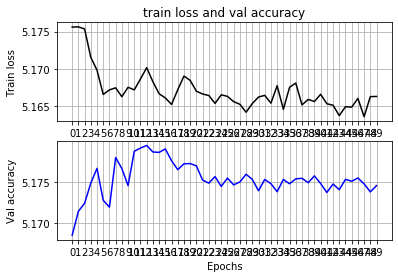

In [0]:
# Train the network


for epoch in range(EPOCHS):  

    net.train()

    predictions = []
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):

        inputs, yards = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            yards = yards.cuda()

        inputs, yards = Variable(inputs), Variable(yards)

        optimizer.zero_grad()

        pred_yards = net(inputs.float())
        loss = loss_f(pred_yards.view(-1,199), yards.long().view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)
    print('[%d] loss: %f' % (epoch + 1, running_loss))
        
    # Calculate validation set accuracy of the existing model
    mean_val_loss = eval(valloader, net, loss_f)

    if NET_TYPE == 'classifier':
      val_crps_score = eval_crps(valloader, net)
      print("CRPS Validation Score:", val_crps_score)
      val_crps_over_epochs.append(val_crps_score)


    print('Mean Validation set loss over batches: %f' % (mean_val_loss))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(mean_val_loss)

    scheduler.step(mean_val_loss)


plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(len(train_loss_over_epochs)), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(len(train_loss_over_epochs), dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(val_accuracy_over_epochs)), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(len(val_accuracy_over_epochs), dtype=int))
plt.grid(True)
plt.savefig("plot.png")
# plt.close(fig)
print('Finished Training')